230207

y1' = y2

y2' = lamb*(1-y1**2)*y2 - y1

t 범위는 [0, 2*lamb]

bias = [2, 0]

lamb = 2

In [8]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
import math
from openpyxl import Workbook

In [43]:
def VDPol_x(n = 20, lamb = 2):
    x = np.linspace(0, 2*lamb, n).reshape((-1, 1))
    x = x.reshape(-1, 1)    # (x크기, 1)
    x = tf.constant(x, dtype = tf.float32)  # tensor 상수로 변형

    return x

def VDPol_y(x, w, idx, bias, y_n = 2): 
    '''
        y1(x) = bias[idx] + w1*(x) + w2*(x**2) + w3*(x**3) + w4*(x**4) + ... + wn*(x**n)
        y2(x) = w1*(x) + w2*(x**2) + w3*(x**3) + w4*(x**4) + ... + wn*(x**n)
    '''
    w = w.v[idx]
    n = w.shape[0]

    y = bias
    for i in range(1, n+1):
        y += w[i-1]*x**i

    return y

def VDPol_loss(x, w, lamb = 2, bias = [2, 0]):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(x)
        y1, y2 = [VDPol_y(x, w, idx = idx, bias = b) for idx, b in enumerate(bias)]
        d_y1 = tape.gradient(y1, x)
        d_y2 = tape.gradient(y2, x)

        # y1' = y2
        # y2' = lamb*(1-y1**2)*y2 - y1
        loss_1 = d_y1 - y2
        loss_2 = d_y2 - (lamb*(1-y1**2)*y2 - y1)
        square_loss = tf.square(loss_1) + tf.square(loss_2)
        total_loss = tf.reduce_mean(square_loss)

        grad_w = tape.gradient(total_loss, w.trainable_variables)
    return grad_w, total_loss

def VDPol_w(w_n, y_n = 2, n = 20, lamb = 2, bias = [2, 0]):
    # custom train_x
    train_x = VDPol_x(n = n, lamb = lamb)

    learning_rate = 1e-3
    optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)

    w = tf.Module()
    w.v = tf.Variable(tf.random.normal(shape=(y_n, w_n), dtype=tf.float32))

    print('Start VDPol : {}차'.format(w_n))
    save_loss = 0
    for itr in range(10001):
        # custom loss
        grad_w, total_loss = VDPol_loss(train_x, w, lamb = lamb, bias = bias)
        optimizer.apply_gradients(zip(grad_w, w.trainable_variables))

        if itr % 5000 == 0:
            print('iter : {}, y_loss : {}'.format(itr, total_loss.numpy()))
            if save_loss == total_loss: break
            save_loss = total_loss
    return w

In [44]:
w_1 = VDPol_w(w_n = 1, n = 20, lamb = 2, bias = [2, 0])
w_2 = VDPol_w(w_n = 2, n = 20, lamb = 2, bias = [2, 0])
w_3 = VDPol_w(w_n = 3, n = 20, lamb = 2, bias = [2, 0])

Start VDPol : 1차
iter : 0, y_loss : 4.689938545227051
iter : 5000, y_loss : 1.0348114967346191
iter : 10000, y_loss : 1.0348113775253296
Start VDPol : 2차
iter : 0, y_loss : 635159.5
iter : 5000, y_loss : 18.936054229736328
iter : 10000, y_loss : 12.359984397888184
Start VDPol : 3차
iter : 0, y_loss : 6778100736.0
iter : 5000, y_loss : 2792323.5
iter : 10000, y_loss : 172536.015625


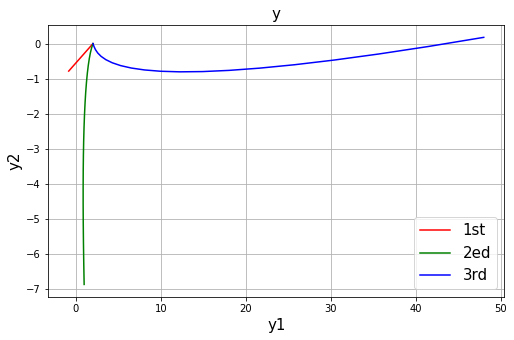

In [45]:
# show_graph
lamb = 2
bias = [2, 0]
test_x = np.linspace(0, 2*lamb, 20, dtype = 'float32')
train_x = np.linspace(0, 2*lamb, 20).reshape((-1, 1))

fig = plt.figure(figsize=(18,5))
ax = fig.add_subplot(121)

y11, y12 = [VDPol_y(test_x, w_1, idx = idx, bias = b) for idx, b in enumerate(bias)]
y21, y22 = [VDPol_y(test_x, w_2, idx = idx, bias = b) for idx, b in enumerate(bias)]
y31, y32 = [VDPol_y(test_x, w_3, idx = idx, bias = b) for idx, b in enumerate(bias)]

ax.plot(y11, y12, '-r', label = '1st')
ax.plot(y21, y22, '-g', label = '2ed')
ax.plot(y31, y32, '-b', label = '3rd')
ax.set_xlabel('y1', fontsize=15)
ax.set_ylabel('y2', fontsize=15)
ax.set_title('y', fontsize=15)
ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.grid()

In [46]:
def model_create(n):
    model_dic = dict()
    for i in range(1, n+1):
        model_dic['model_{}'.format(i)] = tf.keras.models.Sequential([
            tf.keras.layers.Input((1,)),
            tf.keras.layers.Dense(units = 32, activation = 'tanh'),
            tf.keras.layers.Dense(units = 64, activation = 'tanh'),
            tf.keras.layers.Dense(units = 64, activation = 'tanh'),
            tf.keras.layers.Dense(units = 32, activation = 'tanh'),
            tf.keras.layers.Dense(units = 1)
        ])
        
    return model_dic

def VDPol_y_EC(x, w, NN, idx, bias):
    '''
        y1(x) = bias[idx] + w1*(x) + w2*(x**2) + w3*(x**3) + w4*(x**4) + ... + wn*(x**n) + y1_NN(x)*x
        y2(x) = w1*(x) + w2*(x**2) + w3*(x**3) + w4*(x**4) + ... + wn*(x**n) + y2_NN(x)*x
    '''
    y = bias[idx]
    w = w.v[idx]
    n = w.shape[0]
    for i in range(1, n+1):
        y += w[i-1]*x**i

    return y + NN[idx](x)*x

def VDPol_y_EC_loss(x, w, y_NN, lamb = 2, bias = [2, 0]):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(x)
        
        y1 = VDPol_y_EC(x, w, y_NN, 0, bias)
        y2 = VDPol_y_EC(x, w, y_NN, 1, bias)
        d_y1 = tape.gradient(y1, x)
        d_y2 = tape.gradient(y2, x)

        # y1' = y2
        # y2' = lamb*(1-y1**2)*y2 - y1
        loss_1 = d_y1 - y2
        loss_2 = d_y2 - (lamb*(1 - y1**2)*y2 - y1)

    square_loss = tf.square(loss_1) + tf.square(loss_2)
    total_loss = tf.reduce_mean(square_loss)

    return total_loss

def VDPol_EC_train(w, lamb, bias):
    # custom train_x
    x = VDPol_x(n = 20, lamb = lamb)

    learning_rate = 1e-3
    optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)

    # custom model
    model_dic = model_create(n=2)
    y_NN = list(model_dic.values())

    save_loss = 0
    for itr in range(10001):
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(x)

            # custom loss
            total_loss = VDPol_y_EC_loss(x, w, y_NN, lamb = lamb, bias = bias)
            grad_y = tape.gradient(total_loss, [model.trainable_variables for model in y_NN])
        
        for grad, model in zip(grad_y, y_NN):
            optimizer.apply_gradients(zip(grad, model.trainable_variables))

        if itr % 5000 == 0:
            print('iter : {}, VDPol_y_total_loss : {}'.format(itr, total_loss.numpy()))
            if save_loss == total_loss: break
            save_loss = total_loss

            
    return y_NN

start w1 EC
iter : 0, VDPol_y_total_loss : 9.565638542175293
iter : 5000, VDPol_y_total_loss : 0.04309000447392464
iter : 10000, VDPol_y_total_loss : 0.02102421224117279
start w2 EC
iter : 0, VDPol_y_total_loss : 167.94729614257812
iter : 5000, VDPol_y_total_loss : 0.021095043048262596
iter : 10000, VDPol_y_total_loss : 0.020092833787202835
start w3 EC
iter : 0, VDPol_y_total_loss : 86349504.0
iter : 5000, VDPol_y_total_loss : 225.1471405029297
iter : 10000, VDPol_y_total_loss : 113.64421081542969


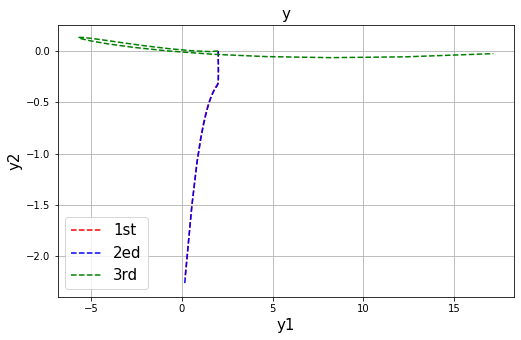

In [47]:
# show_graph
lamb = 2
bias = [2, 0]
test_x = np.linspace(0, 2*lamb, 20, dtype = 'float32').reshape(-1, 1)
train_x = np.linspace(0, 2*lamb, 20).reshape(-1, 1)

print('start w1 EC')
y1_NN = VDPol_EC_train(w_1, lamb = lamb, bias = bias)
print('start w2 EC')
y2_NN = VDPol_EC_train(w_2, lamb = lamb, bias = bias)
print('start w3 EC')
y3_NN = VDPol_EC_train(w_3, lamb = lamb, bias = bias)

fig = plt.figure(figsize=(18,5))
ax = fig.add_subplot(121)

y11_EC, y12_EC = VDPol_y_EC(test_x, w_1, y1_NN, 0, bias = bias), VDPol_y_EC(test_x, w_1, y1_NN, 1, bias = bias)
y21_EC, y22_EC = VDPol_y_EC(test_x, w_2, y2_NN, 0, bias = bias), VDPol_y_EC(test_x, w_2, y2_NN, 1, bias = bias)
y31_EC, y32_EC = VDPol_y_EC(test_x, w_3, y3_NN, 0, bias = bias), VDPol_y_EC(test_x, w_3, y3_NN, 1, bias = bias)

ax.plot(y11_EC, y12_EC, '--r', label = '1st')
ax.plot(y21_EC, y22_EC, '--b', label = '2ed')
ax.plot(y31_EC, y32_EC, '--g', label = '3rd')
ax.set_xlabel('y1', fontsize=15)
ax.set_ylabel('y2', fontsize=15)
ax.set_title('y', fontsize=15)
ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.grid()

Start VDPol : 1차
iter : 0, y_loss : 24.218660354614258
iter : 5000, y_loss : 1.0348114967346191
iter : 10000, y_loss : 1.0348114967346191
Start VDPol : 2차
iter : 0, y_loss : 35797320.0
iter : 5000, y_loss : 2465.299560546875
iter : 10000, y_loss : 453.7298278808594
Start VDPol : 3차
iter : 0, y_loss : 1650028445696.0
iter : 5000, y_loss : 92788712.0
iter : 10000, y_loss : 66272468.0


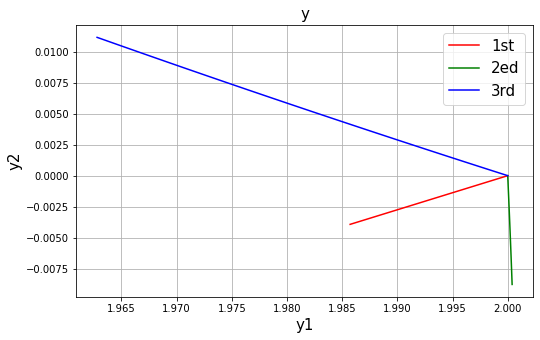

In [48]:
w_1 = VDPol_w(1)
w_2 = VDPol_w(2)
w_3 = VDPol_w(3)

# show_graph
lamb = 0.01
bias = [2, 0]
test_x = np.linspace(0, 2*lamb, 20, dtype = 'float32')
train_x = np.linspace(0, 2*lamb, 20).reshape((-1, 1))

fig = plt.figure(figsize=(18,5))
ax = fig.add_subplot(121)

y11, y12 = [VDPol_y(test_x, w_1, idx = idx, bias = b) for idx, b in enumerate(bias)]
y21, y22 = [VDPol_y(test_x, w_2, idx = idx, bias = b) for idx, b in enumerate(bias)]
y31, y32 = [VDPol_y(test_x, w_3, idx = idx, bias = b) for idx, b in enumerate(bias)]

# ax.plot(tf.math.cos(test_x), tf.math.sin(test_x), '--k', label = 'Exact')
ax.plot(y11, y12, '-r', label = '1st')
ax.plot(y21, y22, '-g', label = '2ed')
ax.plot(y31, y32, '-b', label = '3rd')
ax.set_xlabel('y1', fontsize=15)
ax.set_ylabel('y2', fontsize=15)
ax.set_title('y', fontsize=15)
ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.grid()

# Error
# ax2 = fig.add_subplot(122)
# ax2.plot(tf.abs(tf.math.cos(test_x) - y11) + tf.abs(tf.math.sin(test_x) - y12), '-r', label = '1st Error')
# ax2.plot(tf.abs(tf.math.cos(test_x) - y21) + tf.abs(tf.math.sin(test_x) - y22), '-g', label = '2ed Error')
# ax2.plot(tf.abs(tf.math.cos(test_x) - y31) + tf.abs(tf.math.sin(test_x) - y32), '-b', label = '3rd Error')
# ax2.set_xlabel('y1 Error', fontsize=15)
# ax2.set_ylabel('y2 Error', fontsize=15)
# ax2.set_title('Error', fontsize=15)
# ax2.tick_params(labelsize=10)
# ax2.legend(fontsize=15)
# ax2.grid()

In [49]:
# show_graph
lamb = 0.01
bias = [2, 0]

print('start w1 EC')
y1_NN = VDPol_EC_train(w_1, lamb = lamb, bias = bias)
print('start w2 EC')
y2_NN = VDPol_EC_train(w_2, lamb = lamb, bias = bias)
print('start w3 EC')
y3_NN = VDPol_EC_train(w_3, lamb = lamb, bias = bias)

start w1 EC
iter : 0, VDPol_y_total_loss : 3.704592227935791
iter : 5000, VDPol_y_total_loss : 1.8111738497861296e-10
iter : 10000, VDPol_y_total_loss : 5.849307704863804e-09
start w2 EC
iter : 0, VDPol_y_total_loss : 2.438692092895508
iter : 5000, VDPol_y_total_loss : 4.759039343160687e-11
iter : 10000, VDPol_y_total_loss : 3.908790624507219e-09
start w3 EC
iter : 0, VDPol_y_total_loss : 9.908527374267578
iter : 5000, VDPol_y_total_loss : 8.000134776864343e-09
iter : 10000, VDPol_y_total_loss : 1.880690069810953e-05


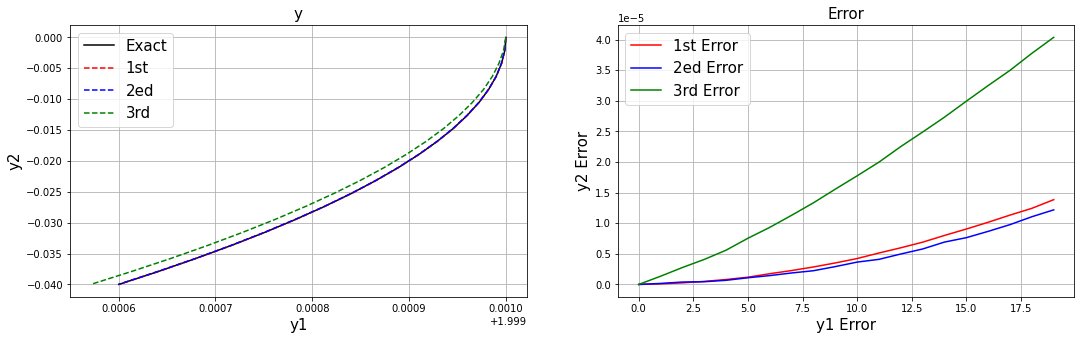

In [50]:
test_x = np.linspace(0, 2*lamb, 20, dtype = 'float32').reshape(-1, 1)
train_x = np.linspace(0, 2*lamb, 20).reshape(-1, 1)

fig = plt.figure(figsize=(18,5))
ax = fig.add_subplot(121)

y11_EC, y12_EC = VDPol_y_EC(test_x, w_1, y1_NN, 0, bias), VDPol_y_EC(test_x, w_1, y1_NN, 1, bias)
y21_EC, y22_EC = VDPol_y_EC(test_x, w_2, y2_NN, 0, bias), VDPol_y_EC(test_x, w_2, y2_NN, 1, bias)
y31_EC, y32_EC = VDPol_y_EC(test_x, w_3, y3_NN, 0, bias), VDPol_y_EC(test_x, w_3, y3_NN, 1, bias)

ax.plot(2*tf.math.cos(test_x), -2*tf.math.sin(test_x), '-k', label = 'Exact')
ax.plot(y11_EC, y12_EC, '--r', label = '1st')
ax.plot(y21_EC, y22_EC, '--b', label = '2ed')
ax.plot(y31_EC, y32_EC, '--g', label = '3rd')
ax.set_xlabel('y1', fontsize=15)
ax.set_ylabel('y2', fontsize=15)
ax.set_title('y', fontsize=15)
ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.grid()

# Error
ax2 = fig.add_subplot(122)
ax2.plot(tf.abs(2*tf.math.cos(test_x) - y11_EC) + tf.abs(-2*tf.math.sin(test_x) - y12_EC), '-r', label = '1st Error')
ax2.plot(tf.abs(2*tf.math.cos(test_x) - y21_EC) + tf.abs(-2*tf.math.sin(test_x) - y22_EC), '-b', label = '2ed Error')
ax2.plot(tf.abs(2*tf.math.cos(test_x) - y31_EC) + tf.abs(-2*tf.math.sin(test_x) - y32_EC), '-g', label = '3rd Error')
ax2.set_xlabel('y1 Error', fontsize=15)
ax2.set_ylabel('y2 Error', fontsize=15)
ax2.set_title('Error', fontsize=15)
ax2.tick_params(labelsize=10)
ax2.legend(fontsize=15)
ax2.grid()